In [148]:
%load_ext autoreload

%autoreload 2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack, join
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
#import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
#import CL_Likelihood_for_Mass_richness_relation as mass_richness
#import CL_fiducial_mass_richness_relation as fiducial
#import analysis_Mass_richness_relation as analysis


import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
clmm.theory.compute_excess_surface_density_2h

<function clmm.theory.func_layer.compute_excess_surface_density_2h(r_proj, z_cl, cosmo, halobias=1.0, lsteps=500, validate_input=True)>

In [150]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [151]:
ind_profile = np.load('../data/data_new_version/ind_profile_redmapper.pkl', allow_pickle = True)
ind_profile['cluster_id'] = ind_profile['id']
ind_profile['richness_redmapper'] = ind_profile['richness']

In [152]:
dat_RM = np.load('../data/lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl', allow_pickle = True)
match = np.load('../data/astropy_proximity_matching_dm_halos_redmapper_clusters.pkl', allow_pickle = True)
print(match['obs_2'])
match['id'] = match['id_2']
match_cut = match[match['obs_2'] > 20]

  obs_2  
---------
 49.49135
 54.15937
 31.45997
22.947695
32.237976
108.03994
 54.26616
 89.55091
31.017576
34.877083
      ...
  28.3327
22.093416
21.910357
24.244368
61.878387
 25.84614
 28.36321
34.449944
 83.23535
20.964548
 54.61702
Length = 4170 rows


In [153]:
ind_profile_match = join(ind_profile, Table(match_cut), keys=['id'])
print(0)

0


In [154]:
ind_profile_match.colnames

['id',
 'ra',
 'dec',
 'redshift',
 'richness',
 'DSt_true',
 'DSx_true',
 'W_l_true',
 'radius_true',
 'DSt_flex',
 'DSx_flex',
 'W_l_flex',
 'radius_flex',
 'DSt_bpz',
 'DSx_bpz',
 'W_l_bpz',
 'radius_bpz',
 'cluster_id',
 'richness_redmapper',
 'obs_1',
 'obs_2',
 'ra_1',
 'ra_2',
 'dec_1',
 'dec_2',
 'redshift_1',
 'redshift_2',
 'id_1',
 'id_2']

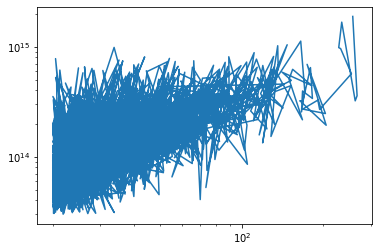

In [155]:
plt.loglog(ind_profile_match['obs_2'], ind_profile_match['obs_1'])
ind_profile_match['M200c'] = ind_profile_match['obs_1']

In [156]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
Gamma_5 = 0.75
Gamma_10 = 0.8

In [157]:
Obs_bin

[[20.0, 52.5], [52.5, 85.0], [85.0, 117.5], [117.5, 150.0]]

# WL masses

## WL shear profiles

In [158]:
profile_sky_stack = prf.stacked_profile(profile = ind_profile_match,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin,
                    add_columns_to_bin = [ 'W_l_true', 'richness', 'redshift','M200c'])

covariance_sky_stack = prf.bootstrap_covariance(profile = ind_profile_match,
    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [159]:
%load_ext autoreload
%autoreload 2
import CL_WL_fit_cluster_mass_v2 as fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
rmax = 5.5
b = 1.
a = 0
fix_c_Duffy08_scatter = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, 
                                                a = a, b = b, rmax = rmax, two_halo_term = False, fix_c = True,  
                                                scatter_lnc = 0.2, scatter_logm = 0, mc_relation = 'Diemer15', method='mcmc')

fitting...
0/20
1.0
1/20
1.0
2/20
1.0
3/20
1.0
4/20
1.0
5/20
1.0
6/20
1.0
7/20
1.0
8/20
1.0
9/20
1.0
10/20
1.0
11/20
1.0
12/20
1.0
13/20
1.0
14/20
1.0
15/20
1.0
16/20
1.0
17/20
1.0
18/20
1.0
19/20
1.0


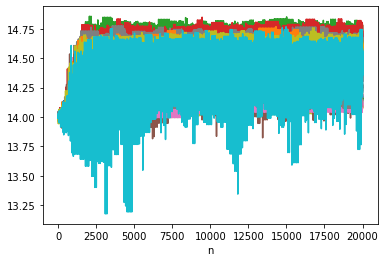

In [161]:
fit.plot_chains(fix_c_Duffy08_scatter, name_param = ['logm'], name_chain='chain')

In [162]:
fit.param_from_chain(fix_c_Duffy08_scatter, name_param = ['logm'], name_chain='chain', n_cut=15500)

In [163]:
Table(fix_c_Duffy08_scatter).colnames

['chain',
 'z_mean',
 'obs_mean',
 'obs_rms',
 'radius',
 'gt',
 'gx',
 'gt_individual',
 'radius_individual',
 'n_stack',
 'cluster_id',
 'z_individual',
 'obs_individual',
 'z_bin',
 'obs_bin',
 'W_l_true',
 'richness',
 'redshift',
 'M200c',
 'logm',
 'logm_err']

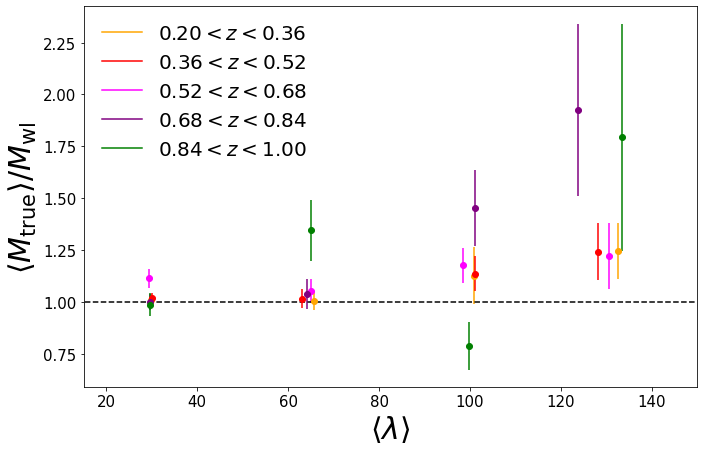

In [169]:
plt.figure(figsize=(11,7))
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
for k, z_bin in enumerate(Z_bin):
    plt.plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
    mask = (fix_c_Duffy08_scatter['z_mean'] > z_bin[0])*(fix_c_Duffy08_scatter['z_mean'] < z_bin[1])
    fit_cut = Table(fix_c_Duffy08_scatter)[mask]
    logm = fit_cut['logm']
    m = 10**logm
    err_m = np.log(10)*fit_cut['logm_err']*m
    true_m_mean = [np.mean(fit_cut['M200c'][i]) for i in range(len(fit_cut['M200c']))]
    true_logm_mean = np.array([np.log10(np.mean(fit_cut['M200c'][i])) for i in range(len(fit_cut['M200c']))])
    plt.errorbar(fit_cut['obs_mean'], true_m_mean/m, err_m*true_m_mean/(m**2),fmt='o', color=color_z[k],)
plt.plot(np.linspace(10, 550, 500), 1+0*np.linspace(20, 500, 500), '--k')
#plt.xscale('log')
plt.legend(frameon = False, loc='upper left', fontsize=20)
plt.xlim(15, 150)
#plt.xscale('log')
plt.xlabel(r'$\langle \lambda \rangle$', fontsize=30)
plt.ylabel(r'$\langle M_{\rm true} \rangle/M_{\rm wl}$', fontsize=30)
plt.tick_params(axis='both', which = 'both', labelsize= 15)
#plt.tick_params(axis='both', which = 'major', labelsize= 20)
#plt.xticks([30,40, 60, 100, 200])